# LES Band Orientation Model Training
---
Central Lake Ontario Buoy Environmental Database

### Carter J. Humphreys
Email: [chumphre@oswego.edu](mailto:chumphre@oswego.edu) | GitHub:[@HumphreysCarter](https://github.com/HumphreysCarter) | Website: [carterhumphreys.com](http://carterhumphreys.com/)

In [3]:
import pickle
import joblib 
import pandas as pd
from pandas.plotting import scatter_matrix
from matplotlib import pyplot
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import max_error, mean_absolute_error, mean_squared_error, r2_score 

# Models
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor

## Load The Data

In [4]:
# Load dataset
dataPath="../data/LO1_dataset.csv"
dataset=pd.read_csv(dataPath)

# Drop unused data
dataset=dataset.drop(['DateTime [UTC]', 'BandAz_LO1 [deg]', 'BandIntensity [dBZ]', 'BandRng_LO1 [km]'], axis=1)

## Dataset Summary

In [5]:
# shape
dataset.shape

(1145, 36)

In [6]:
# head
dataset.head()

,BandStart_Latitude,BandStart_Longitude,BandMidpoint_Latitude,BandMidpoint_Longitude,BandEnd_Latitude,BandEnd_Longitude,WaterTemp_Ontario [degC],IceCover_Ontario [%],IceCover_Huron [%],IceCover_Erie [%],...,RH_700mb [%],u_700mb [kt],v_700mb [kt],bulkshear_925-700hPa [kt],z_500mb [m],T_500mb [degC],RH_500mb [%],u_500mb [kt],v_500mb [kt],bulkshear_925-500hPa [kt]
0,43.535946,-76.223320,43.353896,-75.329963,43.234745,-74.595901,13.26,0.0,0.0,0.0,...,43.55,23.59,-9.42,22.64,5437.26,-30.38,27.49,37.65,-12.40,26.86
1,43.532036,-76.217194,43.334646,-75.373511,43.143089,-74.490379,13.26,0.0,0.0,0.0,...,33.73,22.43,-11.62,26.97,5438.25,-29.61,25.61,36.14,-13.87,30.15
2,43.521149,-76.232010,43.346326,-75.618544,43.195889,-74.990135,13.26,0.0,0.0,0.0,...,37.17,22.20,-12.70,28.10,5432.29,-30.14,19.75,34.44,-13.16,28.75
3,43.518513,-76.217072,43.339364,-75.832468,43.176296,-75.413177,13.26,0.0,0.0,0.0,...,55.30,23.37,-11.55,27.01,5436.76,-30.23,16.43,35.66,-11.93,27.55
4,43.565903,-76.202736,43.259891,-75.604233,42.989628,-75.002983,13.26,0.0,0.0,0.0,...,64.36,23.26,-12.20,26.52,5440.28,-29.95,15.63,35.60,-10.08,23.52


In [7]:
# descriptions
dataset.describe()

,BandStart_Latitude,BandStart_Longitude,BandMidpoint_Latitude,BandMidpoint_Longitude,BandEnd_Latitude,BandEnd_Longitude,WaterTemp_Ontario [degC],IceCover_Ontario [%],IceCover_Huron [%],IceCover_Erie [%],...,RH_700mb [%],u_700mb [kt],v_700mb [kt],bulkshear_925-700hPa [kt],z_500mb [m],T_500mb [degC],RH_500mb [%],u_500mb [kt],v_500mb [kt],bulkshear_925-500hPa [kt]
count,1145.000000,1145.000000,1145.000000,1145.000000,1145.000000,1145.000000,1145.000000,1145.000000,1145.000000,1145.000000,...,1145.000000,1145.000000,1145.000000,1145.000000,1145.000000,1145.000000,1145.000000,1145.000000,1145.000000,1145.000000
mean,43.630653,-76.381776,43.633758,-75.787178,43.639705,-75.142739,4.608821,4.733284,19.422943,23.082725,...,56.317799,32.223721,6.645485,25.328533,5260.147886,-33.079852,34.751860,46.911380,13.336288,33.283066
std,0.233597,0.279259,0.348498,0.408128,0.519221,0.670774,2.408046,6.983989,23.370011,32.730655,...,23.846803,10.059089,14.390203,18.191756,101.036994,5.168124,21.012772,20.137452,25.971267,23.508466
min,43.243790,-77.509819,42.907711,-77.060097,42.608696,-76.938240,1.350000,0.000000,0.000000,0.000000,...,0.970000,7.930000,-33.690000,0.010000,5006.450000,-45.880000,2.260000,-11.000000,-68.130000,0.040000
25%,43.446945,-76.559319,43.339364,-76.035680,43.210049,-75.653412,2.820000,0.070000,0.350000,0.000000,...,36.800000,25.100000,-3.340000,9.670000,5186.260000,-36.770000,16.630000,33.390000,-4.500000,15.150000
50%,43.617672,-76.225258,43.619020,-75.743159,43.589722,-75.121086,3.970000,0.930000,10.440000,2.950000,...,62.770000,31.220000,7.020000,22.360000,5263.640000,-33.150000,30.990000,45.340000,13.650000,29.920000
75%,43.780396,-76.199753,43.901171,-75.471099,44.032555,-74.616837,6.140000,8.160000,33.500000,46.790000,...,76.850000,38.390000,17.640000,38.040000,5321.090000,-28.890000,52.050000,60.680000,31.990000,47.450000
max,44.314522,-76.050560,44.518521,-74.867294,44.987915,-73.680901,13.260000,24.930000,88.300000,95.120000,...,99.130000,65.960000,45.270000,85.010000,5560.780000,-21.190000,98.090000,105.660000,83.550000,132.820000


In [8]:
# class distribution
dataset.groupby(['BandStart_Latitude', 'BandStart_Longitude']).size()

BandStart_Latitude  BandStart_Longitude
43.243790           -77.509819             1
43.248756           -77.003174             1
43.253349           -77.061295             1
43.254963           -77.477936             1
43.257233           -77.469215             1
                                          ..
44.259010           -76.164742             1
44.267601           -76.164268             1
44.309586           -76.296242             1
44.310493           -76.092506             1
44.314522           -76.264351             1
Length: 1102, dtype: int64

## Data Visualization

In [9]:
# box and whisker plots
#dataset.plot(figsize=(20, 20), kind='box', subplots=True, layout=(6,6), sharex=False, sharey=False)
#pyplot.show()

In [10]:
# histograms
#dataset.hist(figsize=(20,20), layout=(6,6))
#pyplot.show()

In [11]:
# scatter plot matrix
#scatter_matrix(dataset, figsize=(20,20))
#pyplot.show()

## Algorithms

In [12]:
# Split-out validation dataset
array = dataset.values
X = array[:,6:36]
y = array[:,0:6]
X_train, X_validation, Y_train, Y_validation = train_test_split(X, y, test_size=0.30, random_state=1)
print(y)
print(X)

[[ 43.535946   -76.22332     43.35389555 -75.329963    43.234745
  -74.595901  ]
 [ 43.532036   -76.217194    43.33464587 -75.37351127  43.143089
  -74.490379  ]
 [ 43.521149   -76.23201     43.34632558 -75.61854384  43.195889
  -74.990135  ]
 ...
 [ 43.553471   -76.185211    43.228888   -75.63504386  42.98103
  -75.192307  ]
 [ 43.320927   -76.710991    43.121541   -76.32067063  42.869659
  -75.870171  ]
 [ 43.384274   -76.656464    43.12864013 -76.4084122   42.85833
  -75.925262  ]]
[[ 13.26   0.     0.   ...  37.65 -12.4   26.86]
 [ 13.26   0.     0.   ...  36.14 -13.87  30.15]
 [ 13.26   0.     0.   ...  34.44 -13.16  28.75]
 ...
 [  2.23   4.63  19.43 ...  30.79   9.28  22.16]
 [  2.23   4.63  19.43 ...  32.32   5.9   25.14]
 [  2.23   4.63  19.43 ...  33.84   1.33  32.51]]


In [16]:
# Spot Check Algorithms
models = []
models.append(('MultiLR', LinearRegression()))
models.append(('KNN(n=2)', KNeighborsRegressor(n_neighbors=2)))
models.append(('KNN(n=5)', KNeighborsRegressor(n_neighbors=5)))
#models.append(('DecisionTree', DecisionTreeRegressor()))
models.append(('RandomForest', RandomForestRegressor()))
#models.append(('MLPR', MLPRegressor()))

# evaluate each model in turn
results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=5, random_state=1, shuffle=True)
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold)
    if name != 'MultiLR': # Hide MultiLR since data is skewed 
        results.append(cv_results)
        names.append(name)
    print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))

MultiLR: 0.425853 (0.025016)
KNN(n=2): 0.730083 (0.026079)
KNN(n=5): 0.646512 (0.042740)
RandomForest: 0.672910 (0.029465)


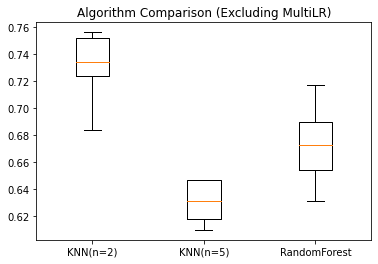

In [17]:
# Compare Algorithms
pyplot.boxplot(results, labels=names, showfliers=False)
pyplot.title('Algorithm Comparison (Excluding MultiLR)')
pyplot.show()

## Predictions and Validation

==================== MultiLR ====================


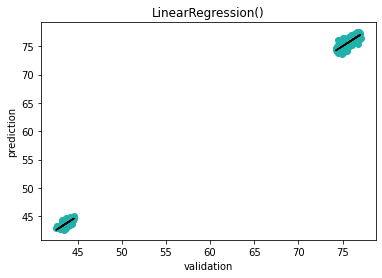

Metric			Curr Score		Prev Score
----------		---------		--------
mean_absolute_error	0.23557716453904506	0.23557716453904506
mean_squared_error	0.10159826658954162	0.10159826658954162
r2_score		0.49441514623178834	0.49441514623178834


==================== KNN(n=2) ====================


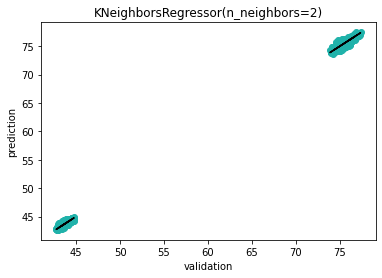

Metric			Curr Score		Prev Score
----------		---------		--------
mean_absolute_error	0.12803433546258147	0.12803433546258147
mean_squared_error	0.04072753828757389	0.04072753828757389
r2_score		0.7956182263584196	0.7956182263584196


==================== KNN(n=5) ====================


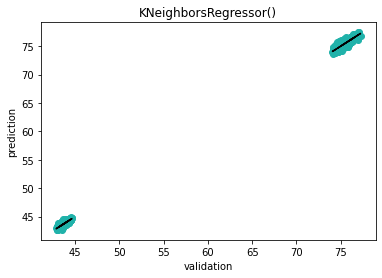

Metric			Curr Score		Prev Score
----------		---------		--------
mean_absolute_error	0.14997936865891015	0.14997936865891015
mean_squared_error	0.04849059244662963	0.04849059244662963
r2_score		0.7494852425557305	0.7494852425557305


==================== RandomForest ====================


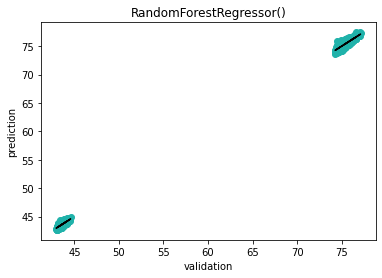

Metric			Curr Score		Prev Score
----------		---------		--------
mean_absolute_error	0.15567401796275404	0.15643471977452453
mean_squared_error	0.04928230827419643	0.049522393239111916
r2_score		0.7505610172709655	0.7472510928726881
Saving model...




In [20]:
for name, model in models:
    print(f'==================== {name} ====================') 
    
    # Make predictions on validation dataset
    model.fit(X_train, Y_train)
    predictions = model.predict(X_validation)
    
    # Evaluate current model
    #currMaxError=max_error(Y_validation, predictions)
    currAbsError=mean_absolute_error(Y_validation, predictions)
    currMeanSqrError=mean_squared_error(Y_validation, predictions)
    currR2score=r2_score(Y_validation, predictions)
    
    # Abs values
    x_abs=[]
    y_abs=[]
    for i in range(len(Y_validation)):
        y_abs.append(abs(Y_validation[i]))
        x_abs.append(abs(predictions[i]))
    
    pyplot.plot(x_abs, x_abs, color='black')
    pyplot.scatter(x_abs, y_abs, marker='o', color='lightseagreen');
    pyplot.title(f'{model}')
    pyplot.xlabel("validation")
    pyplot.ylabel("prediction")
    pyplot.show()   

    # Load previous model and make predictions on validation dataset
    previousModel=joblib.load(f'../models/LES_Band_Position_Model_{name}_LO1_LatLon')  
    previousModel.fit(X_train, Y_train)
    prevPredictions=previousModel.predict(X_validation)
    
    # Evaluate previous model
    #prevMaxError=max_error(Y_validation, prevPredictions)
    prevAbsError=mean_absolute_error(Y_validation, prevPredictions)
    prevMeanSqrError=mean_squared_error(Y_validation, prevPredictions)
    prevR2score=r2_score(Y_validation, prevPredictions)
    
    print('Metric\t\t\tCurr Score\t\tPrev Score')
    print('----------\t\t---------\t\t--------')
    #print(f'max_error\t\t{currMaxError}\t{prevMaxError}')
    print(f'mean_absolute_error\t{currAbsError}\t{prevAbsError}')
    print(f'mean_squared_error\t{currMeanSqrError}\t{prevMeanSqrError}')
    print(f'r2_score\t\t{currR2score}\t{prevR2score}')

    # Save model if r^2 better
    if currR2score > prevR2score:
        print('Saving model...')
        joblib.dump(model, f'../models/LES_Band_Position_Model_{name}_LO1_LatLon') 
    print('\n')